# Importing Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install scikit-plot
!pip install eli5

In [3]:
import datetime
import warnings
# linear algebra
import numpy as np
# data processing
import pandas as pd
import lightgbm as lgb
from tqdm import tqdm_notebook
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
warnings.filterwarnings('ignore')
# data visualization
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import style
from scikitplot.metrics import plot_confusion_matrix,plot_precision_recall_curve
from datetime import time
from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.metrics import roc_auc_score, make_scorer
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode()
import plotly.graph_objs as go
import eli5
from eli5.sklearn import PermutationImportance

Output hidden; open in https://colab.research.google.com to view.

In [0]:
import gc
# Enable automatic garbage collection.
gc.enable()
#For Repreduciton the 
seed = 127
np.random.seed(seed)

# Load & Explore Dataset

In [0]:
paribas_data = pd.read_csv('/content/drive/My Drive/Project with Enas Kh/Thesis/Codes and Dataset/AwE/Treatment/treatment.csv')

In [0]:
train_features, test_features, train_labels, test_labels = train_test_split(
   paribas_data.drop(labels=[], axis=1),
    paribas_data['target'],
    test_size=0.2,
    random_state=41)

In [0]:
#load data
train_df = train_features
test_df = test_features

In [8]:
#Explore the train data
train_df.head()

,id,A,target,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AN
283,284,0,5,3,25.842857,120.000000,120.00000,72.000000,6.000000,10.000000,5.000000,67.000000,9279.928571,355.0,31.810000,68.190000,77.400000,0.000000,34.200000,31.800000,10.000000,24.420000,14.240000,21.000000,6.000000,14.000000,112.000000,58.000000,0.000000,27.000000,3.000000,13.000000,24.000000,3.000000,10.480000,25.640000,12.480000,6.040000,5.640000,3.960000,2.520000
274,275,1,5,3,22.257143,63.000000,120.00000,120.000000,11.000000,27.000000,12.000000,300.000000,9279.928571,335.0,37.060000,62.940000,105.960000,0.000000,51.990000,4.960000,15.960000,21.520000,0.000000,25.000000,9.000000,16.000000,132.000000,72.000000,0.000000,30.000000,2.000000,12.000000,18.000000,0.000000,31.640000,4.880000,6.960000,36.360000,3.400000,7.240000,11.320000
36,37,1,5,24,27.220000,22.000000,110.00000,119.000000,7.000000,12.000000,8.000000,181.000000,14500.000000,433.0,42.810000,57.190000,31.620000,0.000000,10.360000,3.640000,1.320000,6.400000,6.880000,20.000000,12.000000,10.000000,46.000000,29.000000,0.000000,12.000000,3.000000,2.000000,9.000000,2.000000,60.000000,20.000000,22.000000,16.000000,24.000000,6.000000,3.000000
118,119,0,4,24,28.075000,59.966825,70.21327,88.812121,14.733333,21.242424,19.872727,57.000000,0.000000,0.0,32.216187,67.783813,84.548345,0.423309,22.875252,28.543381,9.810288,21.545971,2.464964,18.942446,7.568345,11.244604,81.374101,47.158273,0.496403,17.136691,3.553957,10.028777,19.266187,0.848921,30.495827,16.924029,12.550725,22.457266,13.696978,14.306187,8.524892
108,109,0,3,24,36.177778,59.966825,70.21327,88.812121,14.733333,21.242424,19.872727,166.687273,14075.000000,405.0,32.216187,67.783813,84.548345,0.423309,22.875252,28.543381,9.810288,21.545971,2.464964,18.942446,7.568345,11.244604,81.374101,47.158273,0.496403,17.136691,3.553957,10.028777,19.266187,0.848921,30.495827,16.924029,12.550725,22.457266,13.696978,14.306187,8.524892


In [9]:
#Explore the test data
test_df.head()

,id,A,target,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AN
327,328,1,2,3,22.071429,120.0,120.0,120.000000,8.000000,13.000000,16.000000,221.0,9279.928571,256.635135,42.170000,57.830000,88.600000,0.000000,47.780000,6.200000,22.480000,23.760000,0.000000,33.000000,13.000000,20.000000,173.000000,83.000000,0.000000,38.000000,3.000000,24.000000,22.000000,0.000000,8.000000,31.880000,3.240000,60.000000,2.480000,15.480000,12.640000
315,316,0,1,3,26.357143,120.0,120.0,120.000000,37.000000,15.000000,52.000000,249.0,9279.928571,256.635135,78.100000,21.900000,117.240000,0.000000,18.880000,7.320000,12.800000,56.250000,0.000000,15.000000,10.000000,5.000000,85.000000,60.000000,0.000000,12.000000,1.000000,6.000000,35.000000,0.000000,24.360000,4.400000,2.080000,12.440000,6.800000,6.360000,7.840000
199,200,0,5,24,29.000000,43.0,30.0,88.812121,14.733333,21.242424,19.872727,33.0,9279.928571,232.000000,32.216187,67.783813,84.548345,0.423309,22.875252,28.543381,9.810288,21.545971,2.464964,18.942446,7.568345,11.244604,81.374101,47.158273,0.496403,17.136691,3.553957,10.028777,19.266187,0.848921,30.495827,16.924029,12.550725,22.457266,13.696978,14.306187,8.524892
230,231,0,5,24,32.880000,22.0,17.0,120.000000,9.000000,120.000000,19.000000,300.0,9279.928571,418.000000,32.216187,67.783813,84.548345,0.423309,22.875252,28.543381,9.810288,21.545971,2.464964,18.942446,7.568345,11.244604,81.374101,47.158273,0.496403,17.136691,3.553957,10.028777,19.266187,0.848921,30.495827,16.924029,12.550725,22.457266,13.696978,14.306187,8.524892
214,215,0,7,24,30.375000,21.0,22.0,88.812121,14.733333,21.242424,19.872727,81.0,9279.928571,207.000000,32.216187,67.783813,84.548345,0.423309,22.875252,28.543381,9.810288,21.545971,2.464964,18.942446,7.568345,11.244604,81.374101,47.158273,0.496403,17.136691,3.553957,10.028777,19.266187,0.848921,30.495827,16.924029,12.550725,22.457266,13.696978,14.306187,8.524892


In [10]:
#Size Dataset
train_df.shape , test_df.shape

((273, 41), (69, 41))

In [11]:
#count of target in train data
train_df.groupby('target').count()['id']

target
1     19
2     19
3     35
4     59
5    106
6     20
7     15
Name: id, dtype: int64

In [12]:
#data type for train data
pd.DataFrame(train_df.dtypes).transpose()

,id,A,target,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AN
0,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [13]:
#data type for test data
pd.DataFrame(test_df.dtypes).transpose()

,id,A,target,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AN
0,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


# Check for Missing data & data type

In [14]:
#Finding the missing values in train and test data
train_missing=train_df.isnull().sum().sum()
test_missing=test_df.isnull().sum().sum()
print('Missing values in train data :',train_missing)
print('Missing values in test data :',test_missing)

Missing values in train data : 0
Missing values in test data : 0


# Describe Data

In [15]:
# describe train
train_df.describe()

,id,A,target,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AN
count,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000,273.000000
mean,170.805861,0.531136,4.223443,19.769231,28.043694,60.140722,70.406715,88.319858,14.245910,20.444777,19.512554,165.950503,9349.737048,252.737105,31.880956,68.119044,83.904897,0.451744,23.121306,28.407685,9.767170,21.424342,2.344868,19.078768,7.581601,11.382270,82.024640,47.333755,0.527130,17.357341,3.587556,10.028382,19.270772,0.787809,30.648775,16.889746,12.645270,22.635867,13.890053,14.409138,8.511364
std,98.920176,0.499946,1.472006,8.438458,5.431398,35.632144,32.767213,28.936017,10.466132,13.197619,14.322498,71.063346,5173.949569,170.632890,10.634350,10.634350,33.519627,0.712725,9.701575,20.838693,5.806484,10.502090,3.441570,4.233902,2.140259,3.302171,26.056110,16.441152,0.729628,6.689880,1.354985,5.086356,7.419092,1.064940,11.904170,10.749963,8.600523,13.130615,9.139702,9.421434,6.792585
min,1.000000,0.000000,1.000000,3.000000,0.100000,1.000000,2.000000,6.000000,4.000000,5.000000,4.000000,3.000000,0.000000,0.000000,0.000000,4.490000,0.800000,0.000000,0.000000,0.240000,0.000000,1.400000,0.000000,4.000000,0.000000,1.000000,19.000000,2.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,2.000000,1.520000,0.000000,2.000000,1.840000,2.200000,0.840000
25%,86.000000,0.000000,3.000000,24.000000,25.900000,32.000000,54.000000,88.812121,11.000000,15.000000,13.000000,120.000000,9279.928571,0.000000,32.216187,67.783813,84.548345,0.000000,22.875252,25.800000,9.810288,21.520000,0.000000,18.942446,7.568345,11.244604,81.374101,47.158273,0.000000,17.136691,3.553957,10.028777,19.266187,0.000000,30.495827,14.000000,12.000000,21.000000,13.000000,13.400000,6.000000
50%,168.000000,1.000000,5.000000,24.000000,28.400000,59.966825,70.213270,88.812121,14.733333,21.242424,19.872727,166.687273,9279.928571,282.000000,32.216187,67.783813,84.548345,0.423309,22.875252,28.543381,9.810288,21.545971,2.464964,18.942446,7.568345,11.244604,81.374101,47.158273,0.496403,17.136691,3.553957,10.028777,19.266187,0.848921,30.495827,16.924029,12.550725,22.457266,13.696978,14.306187,8.524892
75%,260.000000,1.000000,5.000000,24.000000,31.425000,63.000000,87.000000,119.000000,14.733333,21.242424,19.872727,210.000000,13437.500000,382.000000,32.216187,67.783813,84.548345,0.423309,22.875252,28.543381,9.810288,21.545971,2.464964,18.942446,7.568345,11.244604,81.374101,47.158273,0.496403,17.136691,3.553957,10.028777,19.266187,0.848921,30.495827,16.924029,12.550725,22.457266,13.696978,14.306187,8.524892
max,341.000000,1.000000,7.000000,24.000000,37.660000,120.000000,120.000000,153.000000,120.000000,120.000000,120.000000,300.000000,22387.500000,605.000000,95.510000,100.000000,196.340000,7.080000,57.860000,179.980000,33.720000,94.120000,28.400000,32.000000,18.000000,25.000000,170.000000,121.000000,6.000000,42.000000,10.000000,30.000000,74.000000,11.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000


In [16]:
# describe test
test_df.describe()

,id,A,target,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AN
count,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000,69.000000
mean,174.246377,0.463768,4.391304,19.739130,29.004715,59.278797,69.447902,90.759772,16.661836,24.398331,21.297760,169.602319,9003.729813,272.057775,33.542538,66.457462,87.094161,0.310808,21.901733,29.080268,9.980883,22.027202,2.940125,18.403086,7.515900,10.699927,78.800229,46.463977,0.374831,16.263685,3.421020,10.030341,19.248045,1.090710,29.890685,17.059668,12.176652,21.750629,12.933075,13.898859,8.578417
std,99.352226,0.502339,1.619889,8.507181,4.093517,36.896743,38.155066,28.931856,18.695679,23.387780,17.745073,69.634846,5040.726485,144.994911,14.143416,14.143416,38.832759,0.340720,11.416845,19.232671,6.066952,8.659882,3.749018,5.088252,2.332349,3.800272,29.039382,14.640861,0.431643,7.531601,1.314121,5.784065,5.158441,1.476779,11.613083,11.432211,8.214359,13.474461,9.672100,9.559120,5.939882
min,10.000000,0.000000,1.000000,3.000000,20.828571,4.000000,2.000000,7.000000,5.000000,8.000000,6.000000,5.000000,0.000000,0.000000,0.000000,1.040000,7.840000,0.000000,0.000000,1.440000,0.000000,6.920000,0.000000,5.000000,0.000000,1.000000,21.000000,8.000000,0.000000,0.000000,1.000000,0.000000,6.000000,0.000000,5.000000,2.320000,2.000000,1.240000,1.000000,2.080000,1.000000
25%,87.000000,0.000000,4.000000,24.000000,26.371429,29.000000,41.000000,88.812121,10.000000,17.000000,16.000000,125.000000,9279.928571,237.000000,32.216187,67.783813,84.548345,0.000000,15.280000,16.840000,9.760000,21.545971,1.160000,18.942446,7.568345,11.000000,71.000000,47.158273,0.000000,14.000000,3.000000,8.000000,19.000000,0.848921,30.495827,14.040000,10.000000,15.000000,7.000000,9.560000,7.840000
50%,193.000000,0.000000,5.000000,24.000000,29.385714,59.966825,70.213270,88.812121,14.733333,21.242424,19.872727,166.687273,9279.928571,296.000000,32.216187,67.783813,84.548345,0.423309,22.875252,28.543381,9.810288,21.545971,2.464964,18.942446,7.568345,11.244604,81.374101,47.158273,0.496403,17.136691,3.553957,10.028777,19.266187,0.848921,30.495827,16.924029,12.550725,22.457266,13.696978,14.306187,8.524892
75%,240.000000,1.000000,5.000000,24.000000,32.150000,62.000000,120.000000,120.000000,14.733333,21.242424,19.872727,213.000000,11762.500000,370.000000,32.216187,67.783813,84.548345,0.423309,22.875252,28.543381,9.810288,21.545971,2.464964,18.942446,7.568345,11.244604,81.374101,47.158273,0.496403,17.136691,3.553957,10.028777,19.266187,0.848921,30.495827,16.924029,12.550725,22.457266,13.696978,14.306187,8.524892
max,342.000000,1.000000,7.000000,24.000000,36.828571,120.000000,120.000000,120.000000,120.000000,120.000000,120.000000,300.000000,18987.500000,518.000000,98.960000,100.000000,211.920000,1.960000,58.920000,104.960000,29.640000,56.250000,20.240000,33.000000,15.000000,23.000000,173.000000,88.000000,3.000000,38.000000,8.000000,30.000000,37.000000,8.000000,60.000000,60.000000,59.000000,60.000000,60.000000,60.000000,36.000000


# Distribution of target value

There are 6.95970695970696% target values with 1
There are 6.95970695970696% target values with 2
There are 12.820512820512821% target values with 3
There are 21.611721611721613% target values with 4
There are 38.827838827838825% target values with 5
There are 7.326007326007326% target values with 6
There are 5.4945054945054945% target values with 7


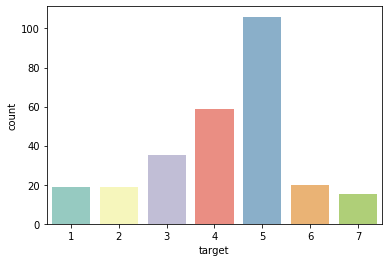

In [18]:
#The distribution of target value in train dataset
sns.countplot(train_df['target'], palette='Set3')

#The data is unbalanced with respect with target value
print("There are {}% target values with 1".format(100 * train_df["target"].value_counts()[1]/train_df.shape[0])),
print("There are {}% target values with 2".format(100 * train_df["target"].value_counts()[2]/train_df.shape[0])),
print("There are {}% target values with 3".format(100 * train_df["target"].value_counts()[3]/train_df.shape[0])),
print("There are {}% target values with 4".format(100 * train_df["target"].value_counts()[4]/train_df.shape[0])),
print("There are {}% target values with 5".format(100 * train_df["target"].value_counts()[5]/train_df.shape[0])),
print("There are {}% target values with 6".format(100 * train_df["target"].value_counts()[6]/train_df.shape[0])),
print("There are {}% target values with 7".format(100 * train_df["target"].value_counts()[7]/train_df.shape[0]))

# scaling dataset

In [19]:
data= train_df 
y = data['target']
X = data.drop(['target', 'id'], axis=1)

#scaling dataset
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(X)
X_scaled = sc.transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled.head()

,A,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AN
0,-1.064337,-1.990888,-0.405951,1.683009,1.516283,-0.565034,-0.789313,-0.792867,-1.015131,-1.394984,-0.013517,0.600416,-0.006685,0.006685,-0.194419,-0.634990,1.144045,0.163088,0.040172,0.285768,3.462658,0.454607,-0.740333,0.794186,1.152529,0.649944,-0.723791,1.444027,-0.434422,0.585306,0.638611,2.081107,-1.697373,0.815475,-0.019252,-1.266227,-0.904319,-1.111118,-0.883665
1,0.939552,-1.990888,-1.067346,0.080392,1.516283,1.096845,-0.310704,0.497610,-0.525492,1.889802,-0.013517,0.482990,0.487905,-0.487905,0.659184,-0.634990,2.981136,-1.127266,1.068496,0.009125,-0.682588,1.401097,0.663940,1.400960,1.921513,1.503030,-0.723791,1.893289,-1.173793,0.388341,-0.171599,-0.741128,0.083420,-1.119241,-0.662252,1.047121,-1.149853,-0.762337,0.414245
2,0.939552,0.502288,-0.151933,-1.072368,1.210539,1.062222,-0.693591,-0.641046,-0.805285,0.212165,0.997250,1.058377,1.029599,-1.029599,-1.562694,-0.634990,-1.317801,-1.190726,-1.457454,-1.433232,1.320171,0.217984,2.068214,-0.419363,-1.385119,-1.117162,-0.723791,-0.802283,-0.434422,-1.581314,-1.386913,1.140362,2.470154,0.289858,1.089691,-0.506302,1.108189,-0.894193,-0.812870
3,-1.064337,0.502288,0.005775,-0.004889,-0.005914,0.017043,0.046657,0.060550,0.025194,-1.535962,-1.810398,-1.483895,0.031581,-0.031581,0.019231,-0.039969,-0.025409,0.006524,0.007439,0.011603,0.034960,-0.032257,-0.006205,-0.041766,-0.025013,-0.010693,-0.042191,-0.033043,-0.024842,0.000078,-0.000619,0.057490,-0.012872,0.003195,-0.011013,-0.013627,-0.021164,-0.010947,0.001995
4,-1.064337,0.502288,1.500355,-0.004889,-0.005914,0.017043,0.046657,0.060550,0.025194,0.010387,0.914957,0.893981,0.031581,-0.031581,0.019231,-0.039969,-0.025409,0.006524,0.007439,0.011603,0.034960,-0.032257,-0.006205,-0.041766,-0.025013,-0.010693,-0.042191,-0.033043,-0.024842,0.000078,-0.000619,0.057490,-0.012872,0.003195,-0.011013,-0.013627,-0.021164,-0.010947,0.001995


In [20]:
#splitting dataset into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=101, stratify=y)
X_train.head()

,A,C,D,E,F,G,H,I,J,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,Y,Z,AA,AB,AC,AD,AE,AF,AG,AH,AI,AJ,AK,AL,AM,AN
103,0.939552,0.502288,0.135814,0.951990,0.507329,1.096845,-0.406426,0.497610,-0.595440,-0.365845,-0.013517,0.576931,0.031581,-0.031581,0.019231,-0.039969,-0.025409,0.006524,0.007439,0.011603,0.034960,-0.032257,-0.006205,-0.041766,-0.025013,-0.010693,-0.042191,-0.033043,-0.024842,0.000078,-0.000619,0.057490,-0.012872,0.003195,-0.011013,-0.013627,-0.021164,-0.010947,0.001995
251,-1.064337,-1.990888,-5.154293,-0.847439,0.018139,1.096845,-0.885035,-0.413315,-0.455543,-0.323552,-0.013517,0.022886,0.031581,-0.031581,0.019231,-0.039969,-0.025409,0.006524,0.007439,0.011603,0.034960,-0.032257,-0.006205,-0.041766,-0.025013,-0.010693,-0.042191,-0.033043,-0.024842,0.000078,-0.000619,0.057490,-0.012872,0.003195,-0.011013,-0.013627,-0.021164,-0.010947,0.001995
246,0.939552,0.502288,-0.026505,-0.622511,1.241114,1.096845,0.072183,-0.792867,-0.245698,0.761979,-0.013517,-1.483895,0.031581,-0.031581,0.019231,-0.039969,-0.025409,0.006524,0.007439,0.011603,0.034960,-0.032257,-0.006205,-0.041766,-0.025013,-0.010693,-0.042191,-0.033043,-0.024842,0.000078,-0.000619,0.057490,-0.012872,0.003195,-0.011013,-0.013627,-0.021164,-0.010947,0.001995
191,-1.064337,0.502288,0.821978,0.417785,-0.562774,1.096845,0.646513,0.193968,1.223220,0.085285,0.735848,0.758941,0.174194,-0.174194,-2.248326,8.023762,-0.851041,0.199626,-1.567878,-1.715599,-0.030527,-1.438373,-0.272242,-1.632912,-1.615814,-2.457725,2.022366,-0.502775,1.783691,-1.581314,-1.792018,0.199617,-2.411037,0.196664,0.390777,0.027783,-1.193699,-0.894193,-1.107849
53,-1.064337,0.502288,0.518949,-0.004889,-0.005914,0.017043,0.046657,0.060550,0.025194,-1.070735,1.377251,0.618030,0.080929,-0.080929,2.808733,-0.634990,-0.499939,0.084725,-1.416045,0.123598,-0.682588,-0.491883,-1.208425,0.187411,-0.039397,3.270136,-0.723791,-0.502775,-0.434422,-1.384349,0.638611,-0.741128,-1.569452,2.899302,-1.007049,-1.269279,-0.645630,-0.575185,0.514538


In [21]:
#size after scale and split
X_train.shape, X_test.shape

((191, 39), (82, 39))

In [0]:
#The scatter plot for train and test set for few of the features
def plot_feature_scatter(df1, df2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(4,4,figsize=(14,14))

    for feature in features:
        i += 1
        plt.subplot(4,4,i)
        plt.scatter(df1[feature], df2[feature], marker='+')
        plt.xlabel(feature, fontsize=9)
    plt.show();

In [0]:
#The scatter plot for 16 features
#features = ['C', 'N', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'AA', 'AD', 'AH', 'AI', 'AJ', 'AK', 'AL', 'AM', 'AN']
#plot_feature_scatter(train_df[::20],test_df[::20], features)

In [0]:
def plot_feature_distribution(df1, df2, label1, label2, features):
    i = 0
    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(10,10,figsize=(18,22))

    for feature in features:
        i += 1
        plt.subplot(10,10,i)
        sns.distplot(df1[feature], hist=False,label=label1)
        sns.distplot(df2[feature], hist=False,label=label2)
        plt.xlabel(feature, fontsize=9)
        locs, labels = plt.xticks()
        plt.tick_params(axis='x', which='major', labelsize=6, pad=-6)
        plt.tick_params(axis='y', which='major', labelsize=6)
    plt.show();

In [4]:
t1 = train_df.loc[train_df['target'] == 1]
t2 = train_df.loc[train_df['target'] == 2]
t3 = train_df.loc[train_df['target'] == 3]
t4 = train_df.loc[train_df['target'] == 4]
t5 = train_df.loc[train_df['target'] == 5]
t6 = train_df.loc[train_df['target'] == 6]
t7 = train_df.loc[train_df['target'] == 7]
features = train_df.columns.values[2:39]
plot_feature_distribution(t1, t2,t3, t4, t5, t6, t7, '1','2','3','4','5','6','7', features)

NameError: ignored

In [5]:
features = train_df.columns.values[2:102]
plot_feature_distribution(train_df, test_df, 'train', 'test', features)

NameError: ignored

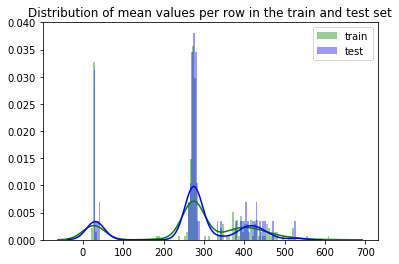

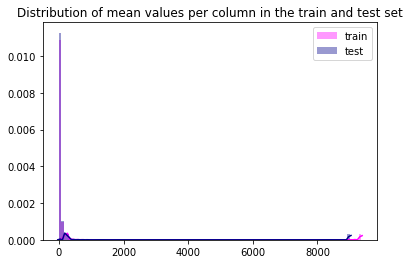

In [25]:
#The distribution of the mean values per row in the train & test set
#plt.figure(figsize=(16,6))
features = train_df.columns.values[2:202]
plt.title("Distribution of mean values per row in the train and test set")
sns.distplot(train_df[features].mean(axis=1),color="green", kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=1),color="blue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

#The distribution of the mean values per column in the train & test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of mean values per column in the train and test set")
sns.distplot(train_df[features].mean(axis=0),color="magenta",kde=True,bins=120, label='train')
sns.distplot(test_df[features].mean(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()



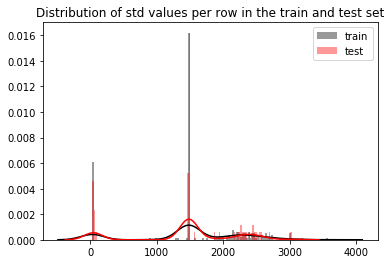

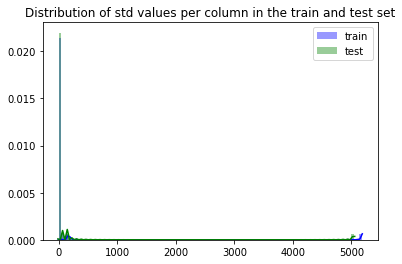

In [26]:
# The distribution of std values per row in the train and test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of std values per row in the train and test set")
sns.distplot(train_df[features].std(axis=1),color="black", kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=1),color="red", kde=True,bins=120, label='test')
plt.legend();plt.show()

# The distribution of std values per column in the train and test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of std values per column in the train and test set")
sns.distplot(train_df[features].std(axis=0),color="blue",kde=True,bins=120, label='train')
sns.distplot(test_df[features].std(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend(); plt.show()

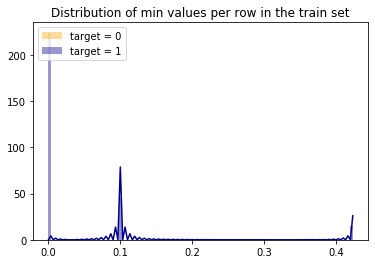

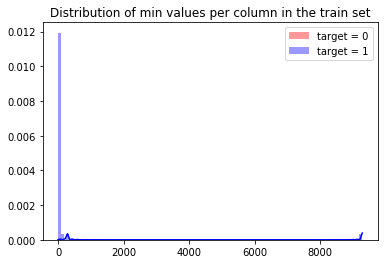

In [27]:
# The distribution of min values per row in the train and test set
t0 = train_df.loc[train_df['target'] == 0]
t1 = train_df.loc[train_df['target'] == 1]
#plt.figure(figsize=(16,6))
plt.title("Distribution of min values per row in the train set")
sns.distplot(t0[features].min(axis=1),color="orange", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

# The distribution of min values per column in the train and test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of min values per column in the train set")
sns.distplot(t0[features].min(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].min(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

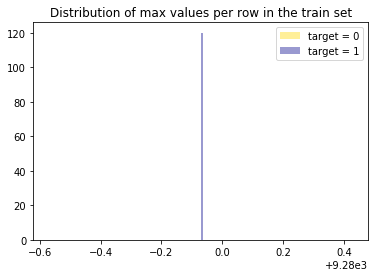

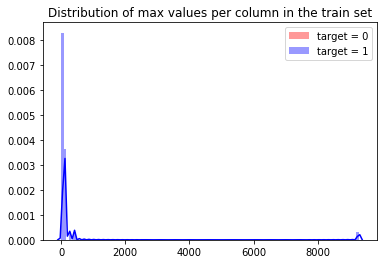

In [28]:
# The distribution of max values per row in the train and test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of max values per row in the train set")
sns.distplot(t0[features].max(axis=1),color="gold", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=1),color="darkblue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

# The distribution of max values per column in the train and test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of max values per column in the train set")
sns.distplot(t0[features].max(axis=0),color="red", kde=True,bins=120, label='target = 0')
sns.distplot(t1[features].max(axis=0),color="blue", kde=True,bins=120, label='target = 1')
plt.legend(); plt.show()

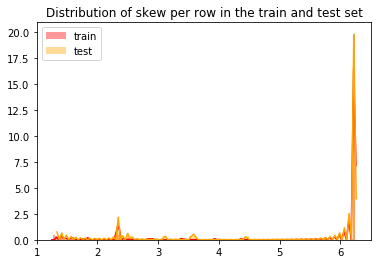

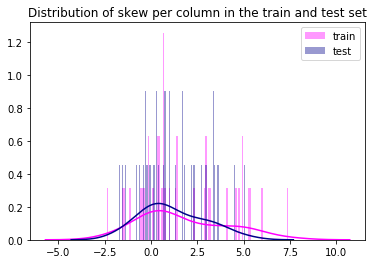

In [29]:
#Distribution of skew per row in the train and test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of skew per row in the train and test set")
sns.distplot(train_df[features].skew(axis=1),color="red", kde=True,bins=120, label='train')
sns.distplot(test_df[features].skew(axis=1),color="orange", kde=True,bins=120, label='test')
plt.legend()
plt.show()

#Distribution of skew per column in the train and test set
#plt.figure(figsize=(16,6))
plt.title("Distribution of skew per column in the train and test set")
sns.distplot(train_df[features].skew(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_df[features].skew(axis=0),color="darkblue", kde=True,bins=120, label='test')
plt.legend()
plt.show()

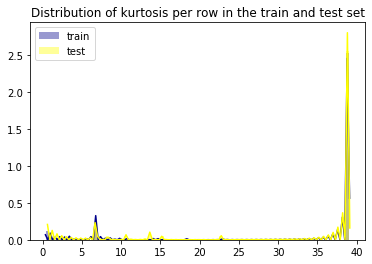

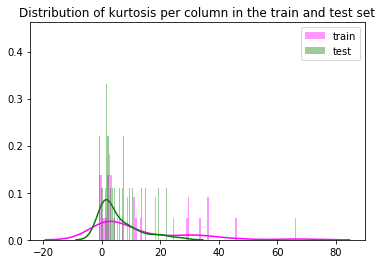

In [31]:
#Distribution of kurtosis per row in the train and test 
#plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per row in the train and test set")
sns.distplot(train_df[features].kurtosis(axis=1),color="darkblue", kde=True,bins=120, label='train')
sns.distplot(test_df[features].kurtosis(axis=1),color="yellow", kde=True,bins=120, label='test')
plt.legend()
plt.show()

#Distribution of kurtosis per column in the train and test 
#plt.figure(figsize=(16,6))
plt.title("Distribution of kurtosis per column in the train and test set")
sns.distplot(train_df[features].kurtosis(axis=0),color="magenta", kde=True,bins=120, label='train')
sns.distplot(test_df[features].kurtosis(axis=0),color="green", kde=True,bins=120, label='test')
plt.legend()
plt.show()


# Correlation between the attributes

In [32]:
#Correlation between the attributes for train data
#Correlations in train attributes
train_attributes=train_df.columns.values[2:202]
train_correlations=train_df[train_attributes].corr().abs().unstack().sort_values(kind='quicksort').reset_index()
train_correlations=train_correlations[train_correlations['level_0']!=train_correlations['level_1']]
train_correlations.head(10)

#print(train_correlations.head(10))
#print(train_correlations.tail(10))

,level_0,level_1,0
0,AN,Q,0.000499
1,Q,AN,0.000499
2,AK,M,0.000829
3,M,AK,0.000829
4,AG,E,0.001532
5,E,AG,0.001532
6,AI,AB,0.001931
7,AB,AI,0.001931
8,P,AC,0.002267
9,AC,P,0.002267


In [33]:
train_correlations.tail(10)

,level_0,level_1,0
1472,Z,Y,0.886889
1473,Y,Z,0.886889
1474,U,AF,0.929143
1475,AF,U,0.929143
1476,T,AE,0.929209
1477,AE,T,0.929209
1478,AC,R,0.932212
1479,R,AC,0.932212
1519,N,O,1.000000
1520,O,N,1.000000


In [34]:
#Correlation between the attributes for test data
#Correlations in test attributes
test_attributes=test_df.columns.values[1:201]
test_correlations=test_df[test_attributes].corr().abs().unstack().sort_values(kind='quicksort').reset_index()
test_correlations=test_correlations[test_correlations['level_0']!=test_correlations['level_1']]
test_correlations.head(10)

#print(test_correlations.head(10))
#print(test_correlations.tail(10))

,level_0,level_1,0
0,G,D,0.000304
1,D,G,0.000304
2,K,AH,0.000355
3,AH,K,0.000355
4,Q,T,0.000726
5,T,Q,0.000726
6,AJ,AA,0.000990
7,AA,AJ,0.000990
8,J,AJ,0.001058
9,AJ,J,0.001058


In [35]:
test_correlations.tail(10)

,level_0,level_1,0
1550,Z,AC,0.903560
1551,AC,Z,0.903560
1552,AC,Y,0.905832
1553,Y,AC,0.905832
1554,AE,T,0.930238
1555,T,AE,0.930238
1556,R,AC,0.962677
1557,AC,R,0.962677
1598,N,O,1.000000
1599,O,N,1.000000


# Correlation plot for train and test data

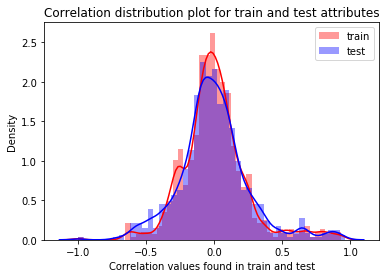

In [36]:
#Correlation plot for train and test data
# correlation between the train and test attributes is very very small
#it means that features are independent each other.
#Correlations in train data
train_correlations=train_df[train_attributes].corr()
train_correlations=train_correlations.values.flatten()
train_correlations=train_correlations[train_correlations!=1]
#Correlations in test data
test_correlations=test_df[test_attributes].corr()
test_correlations=test_correlations.values.flatten()
test_correlations=test_correlations[test_correlations!=1]

#plt.figure(figsize=(20,5))
#Distribution plot for correlations in train data
sns.distplot(train_correlations, color="Red", label="train")
#Distribution plot for correlations in test data
sns.distplot(test_correlations, color="Blue", label="test")
plt.xlabel("Correlation values found in train and test")
plt.ylabel("Density")
plt.title("Correlation distribution plot for train and test attributes")
plt.legend()

In [0]:
#Feature engineering
#Permutation variable importance measure in a random forest for classification
X=train_df.drop(columns=['id','target'],axis=1)
test=test_df.drop(columns=['id'],axis=1)
Y=train_df['target']

In [40]:
#build simple model to find features which are more important
#Split the training data
x_train,x_test,y_train, y_test = train_test_split(X, Y, random_state=42)

print('Shape of X_train :',x_train.shape)
print('Shape of X_test :',x_test.shape)
print('Shape of y_train :',y_train.shape)
print('Shape of y_test:',y_test.shape)

Shape of X_train : (204, 39)
Shape of X_test : (69, 39)
Shape of y_train : (204,)
Shape of y_test: (69,)


In [42]:
#Split the train data using StratefiedKFold cross validator
#Training data
X=train_df.drop(['id','target'],axis=1)
Y=train_df['target']
#StratifiedKFold cross validator
cv=StratifiedKFold(n_splits=5,random_state=42,shuffle=True) #SPLITS=5
for train_index,test_index in cv.split(X,Y):
    x_train, x_test=X.iloc[train_index], X.iloc[test_index]
    y_train, y_test=Y.iloc[train_index], Y.iloc[test_index]

print('Shape of X_train :',x_train.shape)
print('Shape of X_valid :',x_test.shape)
print('Shape of y_train :',y_train.shape)
print('Shape of y_valid :',y_test.shape)

Shape of X_train : (219, 39)
Shape of X_valid : (54, 39)
Shape of y_train : (219,)
Shape of y_valid : (54,)


In [0]:
# Importing Classifier Modules
import datetime, time, json
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier,BaggingClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.svm import LinearSVC, SVC
from sklearn import metrics
# Parameter Tuning
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

# XGB Classifier

In [52]:
 #XGB
import datetime, time, json

print("Starting training at", datetime.datetime.now())
t0 = time.time()

model = XGBClassifier()
model.fit(x_train, y_train)
y_pred_xgb = model.predict(x_test)
acc_xgb = round (metrics.accuracy_score(y_test, y_pred_xgb) *100, 2)
Precision_xgb= round (metrics.precision_score(y_test, y_pred_xgb) *100, 2)
Recall_xgb = round (metrics.recall_score(y_test, y_pred_xgb) *100, 2)
F1_xgb = round (metrics.f1_score(y_test, y_pred_xgb) *100, 7)
ROC_xgb= round (metrics.roc_auc_score(y_test, y_pred_xgb)* 100, 2)  

print("Accuracy for XGBClassifier is: {}".format(acc_xgb))
print("precision_score for XGBClassifier is: {}".format(Precision_xgb))
print("Recall_score for XGBClassifier is: {}".format(Recall_xgb))
print("F1_score for XGBClassifier is: {}".format(F1_xgb))
print("ROC for XGBClassifier is: {}".format(ROC_xgb))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-15 09:14:28.878817


ValueError: ignored

# MLPClassifier  

In [49]:
import datetime, time, json

print("Starting training at", datetime.datetime.now())
t0 = time.time()

from sklearn.neural_network import MLPClassifier  
mlp = MLPClassifier()  
mlp.fit(x_train, y_train) 
y_pred_mlp = mlp.predict(x_test)  


acc_mlp = round (metrics.accuracy_score(y_test, y_pred_mlp) *100, 2)
Precision_mlp= round (metrics.precision_score(y_test, y_pred_mlp) *100, 2)
Recall_mlp = round (metrics.recall_score(y_test, y_pred_mlp) *100, 2)
F1_mlp = round (metrics.f1_score(y_test, y_pred_mlp) *100, 2)
ROC_mlp= round (metrics.roc_auc_score(y_test, y_pred_mlp)* 100, 2)  

print("Accuracy for MLP is: {}".format(acc_mlp))
print("precision_score for MLP is: {}".format(Precision_mlp))
print("Recall_score for MLP is: {}".format(Recall_mlp))
print("F1_score for MLP is: {}".format(F1_mlp))
print("ROC for MLP is: {}".format(ROC_mlp))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2020-03-15 09:05:49.755829


ValueError: ignored

# Linaer SVM

In [0]:
# linear SVM
print("Starting training at", datetime.datetime.now())
t0 = time.time()

linear_svc = LinearSVC(dual=False)
scores = cross_val_score(linear_svc, x_train, y_train, cv=3, scoring = "accuracy")
linear_svc.fit(x_train, y_train)
Y_pred = linear_svc.predict(x_test)
precision_linear_svc = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_linear_svc = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_linear_svc = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_linear_svc = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_linear_svc = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)
print('linear SVM : ')
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2019-11-30 16:29:52.453454
linear SVM : 
Precision: 77.98
Recall: 77.61
Accuracy: 77.84
f1 score: 77.79
ROC: 77.84
Training ended at 2019-11-30 16:33:58.297619
Minutes elapsed: 4.097286


### Naïve Bayes

In [0]:
# NB
print("Starting training at", datetime.datetime.now())
t0 = time.time()

gaussian = GaussianNB()
scores = cross_val_score(gaussian, x_train, y_train, cv=3, scoring="accuracy")
gaussian.fit(x_train, y_train)
Y_pred = gaussian.predict(x_test)
precision_gaussian = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_gaussian = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_gaussian = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_gaussian = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_gaussian= round(roc_auc_score(y_test, Y_pred) * 100, 2)
print('NB : ')
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2019-11-30 16:33:58.322606
NB : 
Precision: 79.98
Recall: 80.02
Accuracy: 80.0
f1 score: 80.0
ROC: 80.0
Training ended at 2019-11-30 16:33:59.372003
Minutes elapsed: 0.017440


# Logistic Regression

In [0]:
# Logistic Regression

print("Starting training at", datetime.datetime.now())
t0 = time.time()

logreg = LogisticRegression(solver='lbfgs')
scores = cross_val_score(logreg, x_train, y_train, cv=3, scoring="accuracy")
logreg.fit(x_train, y_train)
Y_pred = logreg.predict(x_test)
precision_logreg = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_logreg = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_logreg = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_logreg = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_logreg = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)
print('Logistic Regression : ')
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2019-11-30 16:33:59.401985
Logistic Regression : 
Precision: 76.8
Recall: 77.33
Accuracy: 76.98
f1 score: 77.06
ROC: 76.98
Training ended at 2019-11-30 16:34:03.524624
Minutes elapsed: 0.068644


# Decision Tree 

In [0]:
# Decision Tree Gini

print("Starting training at", datetime.datetime.now())
t0 = time.time()

decision_tree = DecisionTreeClassifier()
scores = cross_val_score(decision_tree, x_train, y_train, cv=3)
decision_tree.fit(x_train, y_train)
Y_pred = decision_tree.predict(x_test)
precision_tree_gini = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_tree_gini = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_tree_gini = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_tree_gini = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_tree_gini = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)
print('Desision tree : ')
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2019-12-01 05:22:06.747861
Desision tree : 
Precision: 19.8
Recall: 20.7
Accuracy: 83.61
f1 score: 20.24
ROC: 55.67
Training ended at 2019-12-01 05:33:59.401769
Minutes elapsed: 11.877432


# Random Forest

In [0]:
#RandomForest
print("Starting training at", datetime.datetime.now())
t0 = time.time()

random_forest = RandomForestClassifier()
scores = cross_val_score(random_forest, x_train, y_train, cv=3)
random_forest.fit(x_train, y_train)
Y_pred = random_forest.predict(x_test)
precision_random_forest = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_random_forest = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_random_forest = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_random_forest = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_random_forest = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)
print("random forest : ")
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2019-12-01 05:33:59.429763
random forest : 
Precision: 61.0
Recall: 1.52
Accuracy: 90.01
f1 score: 2.96
ROC: 50.7
Training ended at 2019-12-01 05:37:47.944219
Minutes elapsed: 3.808508


# Gradient Boosting

In [0]:
#GradientBoosting
import datetime, time, json
print("Starting training at", datetime.datetime.now())
t0 = time.time()

gbrt = GradientBoostingClassifier(learning_rate=0.05, n_estimators=300, max_depth=5, subsample=0.5)
scores = cross_val_score(gbrt, x_train, y_train, cv=3)
gbrt.fit(x_train, y_train)
Y_pred = gbrt.predict(x_test)
precision_gbrt = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_gbrt = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_gbrt = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_gbrt = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_gbrt = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)
print("Gradient Boosting Classifier : ")
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2019-11-30 16:35:09.278935
Gradient Boosting Classifier : 
Precision: 80.57
Recall: 77.9
Accuracy: 79.56
f1 score: 79.22
ROC: 79.56
Training ended at 2019-11-30 16:50:50.868044
Minutes elapsed: 15.693052


#  Bagging Classifier with NB

In [0]:
# BaggingClassifier wiht NB
import datetime, time, json
print("Starting training at", datetime.datetime.now())
t0 = time.time()

bag_nb = BaggingClassifier(GaussianNB(), n_estimators=100, n_jobs=1, bootstrap=True, random_state=1)
scores = cross_val_score(bag_nb, x_train, y_train, cv=3)
bag_nb.fit(x_train, y_train)
Y_pred = bag_nb.predict(x_test)
precision_bag_nb = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_bag_nb = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_bag_nb = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_bag_nb = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_bag_nb = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)

print("BaggingClassifier with nb : ")
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2019-11-30 16:50:50.895028
BaggingClassifier with nb : 
Precision: 79.95
Recall: 79.97
Accuracy: 79.96
f1 score: 79.96
ROC: 79.96
Training ended at 2019-11-30 16:52:54.380404
Minutes elapsed: 2.058006


# AdaBoost

In [0]:
#AdaBoost
print("Starting training at", datetime.datetime.now())
t0 = time.time()

ada = AdaBoostClassifier(algorithm="SAMME.R", n_estimators=300, learning_rate=0.2)
scores = cross_val_score(ada, x_train, y_train, cv=3)
ada.fit(x_train, y_train)
Y_pred = ada.predict(x_test)
precision_ada = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_ada = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_ada = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_ada = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_ada = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)
print("Ada Boosting : ")
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2019-11-30 16:52:54.410387
Ada Boosting : 
Precision: 79.59
Recall: 75.86
Accuracy: 78.2
f1 score: 77.68
ROC: 78.2
Training ended at 2019-11-30 17:07:28.996023
Minutes elapsed: 14.576344


# # Voting classifier

In [0]:
# Voting classifier
print("Starting training at", datetime.datetime.now())
t0 = time.time()
from sklearn.ensemble import VotingClassifier
voting_clf = VotingClassifier(estimators=[('lsvm', linear_svc), ('Logistic_Regression', logreg), ('rf', random_forest), ('bd', bag_nb), ('NB', gaussian)],
                              voting='hard')
scores = cross_val_score(voting_clf, x_train, y_train, cv=3)
voting_clf.fit(x_train, y_train)
Y_pred = voting_clf.predict(x_test)
precision_voting = round(metrics.precision_score(y_test, Y_pred) * 100, 2)
recall_voting = round(metrics.recall_score(y_test, Y_pred) * 100, 2)
accuracy_voting = round(metrics.accuracy_score(y_test, Y_pred) * 100, 2)
f1score_voting = round(metrics.f1_score(y_test, Y_pred) * 100, 2)
ROC_voting = round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2)
print("votting : ")
print("Precision:", round(metrics.precision_score(y_test, Y_pred) * 100, 2))
print("Recall:", round(metrics.recall_score(y_test, Y_pred) * 100, 2))
print("Accuracy:", round(metrics.accuracy_score(y_test, Y_pred) * 100, 2))
print("f1 score:", round(metrics.f1_score(y_test, Y_pred) * 100, 2))
print("ROC:", round (metrics.roc_auc_score(y_test, Y_pred)* 100, 2))

t1 = time.time()
print("Training ended at", datetime.datetime.now())
print("Minutes elapsed: %f" % ((t1 - t0) / 60.))

Starting training at 2019-11-30 17:07:29.024007
votting : 
Precision: 79.62
Recall: 78.45
Accuracy: 79.19
f1 score: 79.03
ROC: 79.19
Training ended at 2019-11-30 17:14:00.576817
Minutes elapsed: 6.525797


In [0]:
comparison = pd.DataFrame({
    'Model': ['XGB','MLP','SVM', 'NB', 'LR', 'DT ','RF',
              'GD', 'Bagging with NB', 'Ada Boosting', 'Voting'],
    'Precision': [Precision_xgb,Precision_mlp,precision_linear_svc, precision_gaussian, precision_logreg,
                  precision_tree_gini, precision_random_forest, precision_gbrt,
                  precision_bag_nb, precision_ada, precision_voting ],
    'Recall': [Recall_xgb, Recall_mlp, recall_linear_svc, recall_gaussian, recall_logreg,
                  recall_tree_gini, recall_random_forest, recall_gbrt,
                  recall_bag_nb, recall_ada, recall_voting],
    'F1_score': [F1_xgb, F1_mlp,f1score_linear_svc, f1score_gaussian, f1score_logreg,
                  f1score_tree_gini,f1score_random_forest, f1score_gbrt,
                  f1score_bag_nb, f1score_ada, f1score_voting],
        'ROC': [ROC_xgb,ROC_mlp, ROC_linear_svc, ROC_gaussian, ROC_logreg,
                  ROC_tree_gini, ROC_random_forest, ROC_gbrt,
                  ROC_bag_nb, ROC_ada, ROC_voting],
    'Accuracy': [acc_xgb,acc_mlp, accuracy_linear_svc, accuracy_gaussian, accuracy_logreg,
                  accuracy_tree_gini, accuracy_random_forest, accuracy_gbrt,
                   accuracy_bag_nb, accuracy_ada, accuracy_voting]
})
comparison

,Model,Precision,Recall,F1_score,ROC,Accuracy
0,XGB,77.06,72.21,74.55,75.35,75.35
1,MLP,69.94,66.46,68.16,68.95,68.95
2,SVM,77.98,77.61,77.79,77.84,77.84
3,NB,79.98,80.02,80.00,80.00,80.00
4,LR,76.80,77.33,77.06,76.98,76.98
5,DT,59.59,59.99,59.79,59.65,59.65
6,RF,66.86,54.22,59.88,63.67,63.67
7,GD,80.57,77.90,79.22,79.56,79.56
8,Bagging with NB,79.95,79.97,79.96,79.96,79.96
9,Ada Boosting,79.59,75.86,77.68,78.20,78.20


              Model  Precision  Recall  F1_score    ROC  Accuracy
0               XGB      77.06   72.21     74.55  75.35     75.35
1               MLP      69.94   66.46     68.16  68.95     68.95
2               SVM      77.98   77.61     77.79  77.84     77.84
3                NB      79.98   80.02     80.00  80.00     80.00
4                LR      76.80   77.33     77.06  76.98     76.98
5               DT       59.59   59.99     59.79  59.65     59.65
6                RF      66.86   54.22     59.88  63.67     63.67
7                GD      80.57   77.90     79.22  79.56     79.56
8   Bagging with NB      79.95   79.97     79.96  79.96     79.96
9      Ada Boosting      79.59   75.86     77.68  78.20     78.20
10           Voting      79.62   78.45     79.03  79.19     79.19


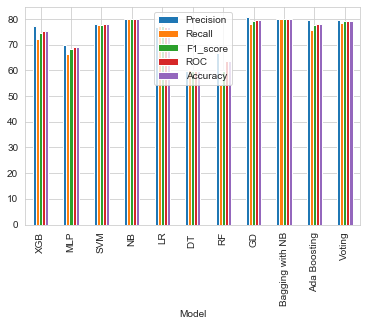

In [0]:
print(comparison)
comparison.plot(x='Model', kind=Model	Precision	Recall	F1_score	ROC	Accuracy
0	XGB	77.06	72.21	74.55	75.35	75.35
1	MLP	69.94	66.46	68.16	68.95	68.95
2	SVM	77.98	77.61	77.79	77.84	77.84
3	NB	79.98	80.02	80.00	80.00	80.00
4	LR	76.80	77.33	77.06	76.98	76.98
5	DT	59.59	59.99	59.79	59.65	59.65
6	RF	66.86	54.22	59.88	63.67	63.67
7	GD	80.57	77.90	79.22	79.56	79.56
8	Bagging with NB	79.95	79.97	79.96	79.96	79.96
9	Ada Boosting	79.59	75.86	77.68	78.20	78.20
10	Voting	79.62	78.45	79.03	79.19	79.19'bar')
plt.show()

In [0]:
#using random forests
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(x_train, y_train)
predictionRFC = rfc.predict_proba(x_test)
predictionRFC

array([[0.4, 0.6],
       [0.6, 0.4],
       [0.6, 0.4],
       ...,
       [0.7, 0.3],
       [0.1, 0.9],
       [0.6, 0.4]])

In [0]:
#probability that a customer will make this transaction (target class 1)
prob = [1 - item[0] for item in predictionRFC] 
prob[:5]

[0.6, 0.4, 0.4, 0.5, 0.6]